<a href="https://colab.research.google.com/github/Zahidlab/OCT-Image-Denoising/blob/main/OCT_Image_Denoiser_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !zip -r /content/patchOCT.zip /content/drive/MyDrive/Research/'OCT datasets'/'Patch OCT Dataset'

In [ ]:
url = "https://drive.google.com/uc?id=1VLaDBx7MU4ZzPOQGnxRjuEP-flF54FiW"
# https://drive.google.com/file/d/1VLaDBx7MU4ZzPOQGnxRjuEP-flF54FiW/view?usp=sharing
# https://drive.google.com/file/d/1VLaDBx7MU4ZzPOQGnxRjuEP-flF54FiW/view?usp=share_link
import gdown
output = '20150428_collected_images.tgz'
gdown.download(url, output, quiet=False)
# gdown.download(url, output = 'oct_patch')

Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1VLaDBx7MU4ZzPOQGnxRjuEP-flF54FiW 



In [ ]:
# !unzip '/content/Patch OCT Dataset.zip'

unzip:  cannot find or open /content/Patch OCT Dataset.zip, /content/Patch OCT Dataset.zip.zip or /content/Patch OCT Dataset.zip.ZIP.


In [ ]:
import os, shutil
from os.path import join, isdir
from os import mkdir, makedirs
import cv2
import sys
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt
from PIL import Image
from timeit import default_timer as timer
from torch.utils.tensorboard import SummaryWriter

In [ ]:
# Find Out if the code is running in Google Colab

COLAB = 'google.colab' in sys.modules

#setting up Device for device agnostic code

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cpu


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
#Mounting Google Drive and setting the Root Data Directory for Colab Environment

if COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  
  # Defining Data Path
  Root_Dir = '/content/drive/MyDrive/Research/OCT datasets'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Setting Specific data path for each different data folder
first_first = os.path.join(Root_Dir,'Fast Acuisition', 'For synthetic experiments')
first_second = os.path.join(Root_Dir,'Fast Acuisition', 'Images for Dictionaries and Mapping leraning')
second = os.path.join(Root_Dir, 'Sparsity Based Denoising... _SDOCT_DATASET_2012_AMD')


## Importing 3 Datasets

In [ ]:
# # First First
# CLEAN_IMAGES = []
# NOISY_IMAGES = []
# IMAGE_PATHS = []
# for folder in os.listdir(first_first):
#   folder_path = os.path.join(first_first, folder)

  


#   clean_img_path = join(folder_path, 'average.tif')
#   noisy_image_path = join(folder_path, '1.tif')

#   IMAGE_PATHS.append([noisy_image_path, clean_img_path, 'FAFSE'])





In [ ]:
# # second dataset
# # IMAGE_PATHS = []
# for folder in sorted(os.listdir(second)):

#   folder_path = os.path.join(second, folder)

#   if os.path.isfile(folder_path):
#     continue
  

#   for img in os.listdir(folder_path):
#     if 'Averaged' in img:

#       clean_img_path = join(folder_path, img)
#     elif 'Raw' in img:

#       noisy_image_path = join(folder_path, img)

#   IMAGE_PATHS.append([noisy_image_path, clean_img_path, 'FAIFD'])

In [ ]:
# # First Second
# print(first_second)
# # Img_paths = []
# for i in range(1,11):
#   clean_image_path = join(first_second, f'HH{i}.tif')

#   noisy_image_path = join(first_second, f'LL{i}.tif')

#   IMAGE_PATHS.append([noisy_image_path, clean_image_path, 'SBD'])

# # Img_paths

### deleting contents of a folder

In [ ]:
import os, shutil
def del_contents(path):
  folder = path
  for filename in os.listdir(folder):
      file_path = os.path.join(folder, filename)
      try:
          if os.path.isfile(file_path) or os.path.islink(file_path):
              os.unlink(file_path)
          elif os.path.isdir(file_path):
              shutil.rmtree(file_path)
      except Exception as e:
          print('Failed to delete %s. Reason: %s' % (file_path, e))

## Saving Images in a single folder

In [ ]:
# # Saving Images in a single folder
# root_dir = '/content/drive/MyDrive/Research/OCT datasets/Organised Dataset'
# dir = root_dir
# if isdir(root_dir):
#   del_contents(root_dir)
# else:
#   mkdir(root_dir)
# clean_dir = join(root_dir, 'Clean')
# noisy_dir = join(root_dir, 'Noisy')

# if not os.path.isdir(clean_dir):
#   os.mkdir(clean_dir)
#   os.mkdir(noisy_dir)

# index = 1
# for n,c,ds in IMAGE_PATHS:

#   folder_name = f"{index:03d} {ds}"

#   clean_folder_path = join(clean_dir, folder_name)

#   if not os.path.isdir(clean_folder_path):
#     os.mkdir(clean_folder_path)

#   file_name = f"{index:03d} {ds}.jpg"
#   clean_image_path = join(clean_folder_path, file_name)
#   shutil.copy(c, clean_image_path)

#   ######################

#   noisy_folder_path = join(noisy_dir, folder_name)

#   if not os.path.isdir(noisy_folder_path):
#     os.mkdir(noisy_folder_path)

#   file_name = f"{index:03d} {ds}.jpg"
#   noisy_image_path = join(noisy_folder_path, file_name)
#   shutil.copy(n, noisy_image_path)


#   index+=1

  

In [ ]:
# len(IMAGE_PATHS)

## Creating Image Patchs

In [ ]:
# # Creating Image Paths

# PATCH_SIZE = 64

# patch_root_dir = "/content/drive/MyDrive/Research/OCT datasets/Patch OCT Dataset"

# if isdir(patch_root_dir):
#   del_contents(patch_root_dir)
# else:
#   os.mkdir(patch_root_dir)

# clean_patch_dir = join(patch_root_dir, 'Clean')
# noisy_patch_dir = join(patch_root_dir, 'Noisy')

# if not isdir(clean_patch_dir):
#   makedirs(clean_patch_dir)
#   makedirs(noisy_patch_dir)

# patch_list = []

# clean_raw_image_dir = '/content/drive/MyDrive/Research/OCT datasets/Organised Dataset/Clean'
# noisy_raw_image_dir = '/content/drive/MyDrive/Research/OCT datasets/Organised Dataset/Noisy'

# for folder in sorted(os.listdir(clean_raw_image_dir)):
#   clean_image_path = join(clean_raw_image_dir, folder, folder+'.jpg')
#   noisy_image_path = join(noisy_raw_image_dir, folder, folder+'.jpg')

#   clean_image = cv2.imread(clean_image_path,0)
#   noisy_image = cv2.imread(noisy_image_path, 0)

#   if(clean_image.shape != noisy_image.shape):
#     print(f"Shape mismatch {clean_image.shape} - {noisy_image.shape} - {folder}")

#   height, width = clean_image.shape

#   clean_patch_folder_path = join(clean_patch_dir, folder)
#   noisy_patch_folder_path = join(noisy_patch_dir, folder)
#   mkdir(clean_patch_folder_path)
#   mkdir(noisy_patch_folder_path)
#   index = 1
#   for h in range(height//PATCH_SIZE):
#     # print(i)
#     for w in range(width//PATCH_SIZE):
#       # print(f"j = {j}")
#       clean_patch = clean_image[h*PATCH_SIZE:(h+1)*PATCH_SIZE , w*PATCH_SIZE:(w+1)*PATCH_SIZE , ]
#       clean_patch_image_path = join(clean_patch_folder_path, f"{index:03d}.jpg")
#       cv2.imwrite(clean_patch_image_path, clean_patch)
#       ######################
#       noisy_patch = noisy_image[h*PATCH_SIZE:(h+1)*PATCH_SIZE , w*PATCH_SIZE:(w+1)*PATCH_SIZE , ]
#       noisy_patch_image_path = join(noisy_patch_folder_path, f"{index:03d}.jpg")
#       cv2.imwrite(noisy_patch_image_path, noisy_patch)

#       # print(clean_patch_image_path, noisy_patch_image_path)


#       patch_list.append([noisy_patch, clean_patch])
#       index+=1

#       # plt.subplot(1,2,1)
#       # plt.imshow(noisy_patch, cmap='gray')
#       # plt.subplot(1,2,2)
#       # plt.imshow(clean_patch, cmap='gray')
#   #     break
#   #   break
#   # break

 

# Loading dataset

In [ ]:
patch_data_dir = '/content/Patch OCT Dataset'
# !unzip '/content/drive/MyDrive/Research/OCT datasets/Patch OCT Dataset.zip'
clean_data_dir = join(patch_data_dir, 'Clean')
noisy_data_dir = join(patch_data_dir, 'Noisy')
IMAGE_PATHS = []

for folder in sorted(os.listdir(clean_data_dir)):
  # print(folder)
  clean_folder_path = join(clean_data_dir, folder)
  noisy_folder_path = join(noisy_data_dir, folder)
  # print(current_folder_path)
  for img in sorted(os.listdir(clean_folder_path)):
    # print(img)

    clean_img_path = join(clean_folder_path, img)
    noisy_img_path = join(noisy_folder_path, img)

    IMAGE_PATHS.append([noisy_img_path, clean_img_path])
    # print(clean_img_path, noisy_img_path)





In [ ]:
len(IMAGE_PATHS)

4708

#  Datasets and Dataloaders

## Creating Dataset

### Custom Dataset Class

In [ ]:
class CustomDataset(Dataset):

  def __init__(self, paths, transform = None):
    self.paths = paths
    self.transform = transform

  def __getitem__(self, index:int, ):

    noisy_img = Image.open(self.paths[index][0])
    clean_img = Image.open(self.paths[index][1])
    # clean_img = transforms.functional.adjust_sharpness(clean_img,sharpness_factor=10)

    if self.transform:
      return self.transform(noisy_img), self.transform(clean_img)

    return noisy_img, clean_img



  def __len__(self):
    return len(self.paths)



### Transformations

In [ ]:
# defining Transforms Needed to be done on the Images
trans = transforms.Compose([
    # transforms.ToPILImage(),
    # transforms.Resize((128,128)),

    transforms.ToTensor(),
    # transforms.Normalize((0.5), (0.5))
])

### Dataset Instance

In [ ]:
# Dataset 
dataset = CustomDataset(IMAGE_PATHS, transform = trans)
len(dataset)

4708

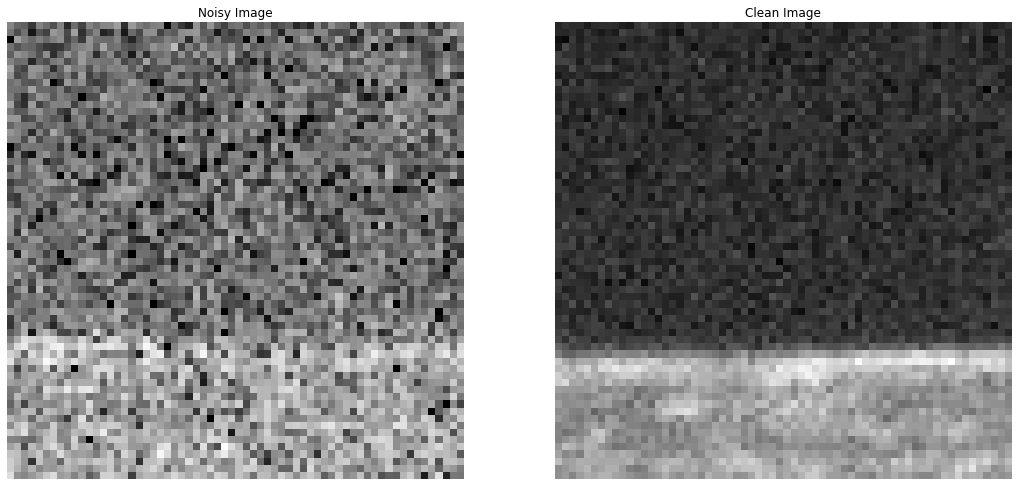

In [ ]:
plt.figure(figsize = (18,18))
plt.subplot(1,2,1)
plt.imshow(dataset[1][0].squeeze(), cmap = 'gray')
plt.title('Noisy Image')
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(dataset[1][1].squeeze(), cmap = 'gray')
plt.title('Clean Image')
plt.axis("off")

n,c = dataset[1][0], dataset[1][1]

## BATCH SIZE

In [ ]:
BATCH_SIZE = 256

## Data Loader

In [ ]:
start_time = timer()
r = torch.tensor([32,1,64,64], device = DEVICE)
print(timer()-start_time)

0.0003979129996878328


In [ ]:
train_dl = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True, pin_memory = True, num_workers = 2)


In [ ]:
writer = SummaryWriter(f'runs/OCT Denoise/first try')

# Model Creation and Training Testing

## Generator Model

In [ ]:
class Generator(nn.Module):

  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        
        # decoder layers
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),
        nn.Sigmoid()
    )


    self.apply(self._init_weights)

  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
      module.weight.data.normal_(mean=0.0, std=1.0)
      if module.bias is not None:
          module.bias.data.zero_()



  def forward(self, x):
    encoded = self.encoder(x)
    # print(encoded.shape)
    # print(f"Shape of encoded: {encoded.shape}")
    decoded = self.decoder(encoded)
    return decoded

### Test Generator Model

In [ ]:
rand_img = torch.randn([32, 1, 64, 64])
rand_img.shape
generator = Generator()

result = generator(rand_img)

torch.Size([1, 1, 64, 64])


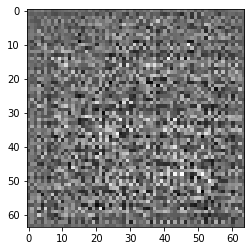

In [ ]:
generator = Generator().to(DEVICE)

x = n.unsqueeze(dim=1)

result = generator(x.to(DEVICE))
print(result.shape)
with torch.inference_mode():
  plt.imshow(result.squeeze().to('cpu'), cmap='gray')

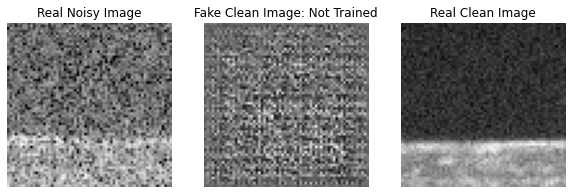

In [ ]:
test_noisy_image = n.to(DEVICE)
gen_clean_image = generator(test_noisy_image.unsqueeze(dim=1)).squeeze()
real_clean_image = c


fig = plt.figure(figsize = (10,10))
with torch.inference_mode():
  fig.add_subplot(1,3,1)
  plt.imshow(test_noisy_image.squeeze().to('cpu'), cmap='gray')
  plt.title("Real Noisy Image")
  plt.axis('off')

  fig.add_subplot(1,3,2)
  plt.imshow(gen_clean_image.to('cpu'), cmap='gray')
  plt.title("Fake Clean Image: Not Trained")
  plt.axis('off')

  fig.add_subplot(1,3,3)
  plt.imshow(real_clean_image.squeeze().to('cpu'), cmap='gray')
  plt.title("Real Clean Image")
  plt.axis('off')

## Discriminitor 

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, input_shape, output_shape):
    super().__init__()

    self.block_1 = nn.Sequential(
        
        nn.Conv2d(
            in_channels = input_shape, 
            out_channels = 64,
            kernel_size = 3,
            # padding=1,
            # stride=1,
        ),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.MaxPool2d(
            kernel_size = 2,
            # stride=2,
        ),

        # 
        nn.Conv2d(
            in_channels = 64, 
            out_channels = 128,
            kernel_size = 3,
            # padding=1,
            # stride=1,

        ),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.MaxPool2d(
            kernel_size = 2,
            # stride=2,
        ),
        # 

        nn.Conv2d(
            in_channels = 128, 
            out_channels = 256,
            kernel_size = 3,
            # padding=1,
            # stride=1,

        ),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.MaxPool2d(
            kernel_size = 2,
            # stride=2,
        ),
        # 

        nn.Conv2d(
            in_channels = 256, 
            out_channels = 512,
            kernel_size = 3,
            # padding=1,
            # stride=1,

        ),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.MaxPool2d(
            kernel_size = 2,
            # stride=2,
        ),


    )


    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = 512*2*2, out_features = 1024),
        nn.ReLU(),
        nn.Linear(in_features = 1024, out_features = output_shape)

    )
  
  def forward(self, x):
    x = self.block_1(x)
    # x = self.block_2(x)
    # print(x.shape)
    x = self.classifier(x)

    return x





### Test Discriminator

In [ ]:
# Test Discriminator
discriminator = Discriminator(1,1).to(DEVICE)
x = torch.rand(size = [20,1,64,64]).to(DEVICE)

r = discriminator(x)
print(r.shape)


torch.Size([20, 1])


## Hyperparameters

In [ ]:
mseloss = nn.MSELoss()
bceloss = nn.BCEWithLogitsLoss()


optim_d = torch.optim.Adam(discriminator.parameters(), lr = 0.001, weight_decay=1e-5)
optim_g = torch.optim.Adam(generator.parameters(), lr = 0.001, weight_decay=1e-5)

## Util Functions

### Show sample

In [ ]:
def show_sample():
  test_noisy_image = n.to(DEVICE)
  gen_clean_image = generator(test_noisy_image.unsqueeze(dim=1)).squeeze()
  real_clean_image = c

  fig = plt.figure(figsize = (10,10))

  with torch.inference_mode():
    fig.add_subplot(1,3,1)
    plt.imshow(test_noisy_image.squeeze().to('cpu'), cmap='gray')
    plt.title("Real Noisy Image")
    plt.axis('off')

    fig.add_subplot(1,3,2)
    plt.imshow(gen_clean_image.to('cpu'), cmap='gray')
    plt.title("Fake Clean Image")
    plt.axis('off')

    fig.add_subplot(1,3,3)
    plt.imshow(real_clean_image.squeeze(), cmap='gray')
    plt.title("Real Clean Image")
    plt.axis('off')

    plt.show()

### PSNR calculation

In [ ]:
from math import log10,sqrt
def PSNR(original, compressed):
    mse = torch.mean((torch.sub(original, compressed)) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = torch.max(original)
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

## Train Step

### Discriminator Trainer

In [ ]:
import torch.nn.functional as F


def train_discriminator(noisy_images, clean_images, optimizer_d):
  optimizer_d.zero_grad()

  preds_for_real = discriminator(clean_images)
  targets_for_real = torch.ones(clean_images.size(0), 1, device = DEVICE)
  
  loss_for_real = bceloss(preds_for_real, targets_for_real)
  real_score = torch.mean(preds_for_real).item()



  fake_clean_images = generator(noisy_images)


  preds_for_fake = discriminator(fake_clean_images)
  targets_for_fake = torch.zeros(fake_clean_images.size(0), 1, device = DEVICE)

  loss_for_fake = bceloss(preds_for_fake, targets_for_fake)

  fake_score = torch.mean(preds_for_fake).item()

  # diff_in_images = mseloss(clean_images, fake_clean_images)
  # writer.add_scalar('Diff in Image', diff_in_images )
  # print(f"Disc Diff in Images: {diff_in_images}")

  loss = loss_for_real + loss_for_fake 
  # print(diff_in_images, loss_for_real, loss_for_fake)
  
  loss.backward()

  optimizer_d.step()

  return loss.item(), real_score, fake_score




### Generator Trainer

In [ ]:
def train_generator(noisy_images, real_images, optimizer_g):

  optimizer_g.zero_grad()


  fake_images = generator(noisy_images)

  preds_for_fake = discriminator(fake_images)

  false_targets_for_fake = torch.ones(fake_images.size(0), 1, device = DEVICE)
  diff_in_images = mseloss(real_images, fake_images)
  # print(f"Diff in Images: {diff_in_images}")
  generator_loss = bceloss(preds_for_fake, false_targets_for_fake)

  # total_loss = generator_loss 
  generator_loss.backward()
  optimizer_g.step()

  return generator_loss.item()

## Fit Function

In [ ]:
from tqdm.notebook import tqdm
Images = []
def fit(EPOCHS, start_idx= 1):
  torch.cuda.empty_cache()

  Gen_Loss = []
  Dis_Loss = []

  Real_Scores = []
  Fake_Scores = []




  for epoch in tqdm(range(EPOCHS)):

    for noisy_images, clean_images in tqdm(train_dl):
      noisy_images = noisy_images.to(DEVICE, non_blocking=True)
      clean_images = clean_images.to(DEVICE, non_blocking=True)

      loss_d, real_score, fake_score = train_discriminator(noisy_images, clean_images, optim_d)
      loss_g = train_generator(noisy_images, clean_images, optim_g)

      # optim_g.zero_grad(set_to_none=True)

      # res = generator(noisy_images)
      # psnr = PSNR(clean_images, res)
      # loss = mseloss(res, clean_images)

      # loss.backward()
      # optim_g.step()


    # print(loss.item())
    # print(f"EPOCH: {epoch+1} | MSE Loss: {loss.item():.4f} | PSNR: {psnr:.4f}")
    # writer.add_scalar('MSE LOSS', loss.item(), global_step = epoch+1)
    # writer.add_scalar('PSNR', psnr, global_step = epoch+1)


    Gen_Loss.append(loss_g)
    Dis_Loss.append(loss_d)
    writer.add_scalar('LOSS D', loss_d, global_step = epoch+1)
    writer.add_scalar('LOSS G', loss_g, global_step = epoch+1)

    Real_Scores.append(real_score)
    Fake_Scores.append(fake_score)

    # show_sample()
    test_noisy_image = n.to(DEVICE)
    gen_clean_image = generator(test_noisy_image.unsqueeze(dim=1)).squeeze()
    real_clean_image = c

    psnr = PSNR(real_clean_image, gen_clean_image)
    writer.add_scalar('PSNR', psnr, global_step = epoch+1)
    writer.add_image('Fake Clean Image', gen_clean_image, dataformats='HW')
    Images.append([test_noisy_image.to('cpu'),gen_clean_image.to('cpu'), real_clean_image])

    print(f"EPOCH: {epoch+1} | Gen Loss: {loss_g:.4f} |  Dis Loss: {loss_d:.4f} | PSNR: {psnr:.4f} \n\n")

    # save_samples(epoch+start_idx, fixed_latent, show = False)
  
  return Gen_Loss, Dis_Loss, Real_Scores, Fake_Scores


In [ ]:
PSNR(torch.rand([32,1,64,64]),torch.rand([32,1,64,64]))


7.771548761611897

## Wrapper

In [ ]:
EPOCHS = 10
from timeit import default_timer as timer

start_time = timer()
history = fit(EPOCHS, )
end_time = timer()

print(f"\nTotal Time Taken: {end_time-start_time} seconds")


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

TypeError: ignored

In [ ]:
show_sample()

In [ ]:
# plt.figure(figsize=(15, 12))
# plt.suptitle("Noisy-Fake-Clean", fontsize=18, y=0.95)
# cols = 3
# rows = EPOCHS
# with torch.inference_mode():
#   index = 1
#   for i in range(rows*cols):
#     for j in range(3):
#       if index>rows*cols:
#         break
#       plt.subplot(rows,cols,index) 
#       plt.imshow(Images[i][j].squeeze().to('cpu'), 'gray')
#       index+=1


In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity
import torch
import torchvision.models as models
model = models.resnet18()
inputs = torch.randn(5, 3, 224, 224)
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CPU], record_shapes=True) as prof:
  with record_function("model_inference"):
    model(inputs)

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))